### Topic:        __Week 01: Challenges 1-10
Subject:      Explore MTA turnstile data  
Date:         09/30/2010  
Name:         Steven Bierer  
Worked with:  Alex, Gretta, Shwetha (and h/t Dan the TA)

## Challenge 1

In [25]:
import pandas as pd
import numpy as np

In [3]:
# Download turnstile .csv files (done) and load some up #
TURNSTILE_PATH = 'supporting_files/'
TURNSTILE_FILES = ['turnstile_180825','turnstile_180901','turnstile_180908']
turnstile_files = [TURNSTILE_PATH + x + '.csv' for x in TURNSTILE_FILES]

tflist = []
for tf in turnstile_files:
    print(f'Opening file {tf[-20:]}')
    df = pd.read_csv(tf, index_col=None, header=0)
    tflist.append(df)
#     try:
#         df = pd.read_csv(tf, index_col=None, header=0)
#         tflist.append(df)
#     except:
#         print(f'  Trouble accessing file -> skipping.')
df = pd.concat(tflist)

Opening file turnstile_180825.csv
Opening file turnstile_180901.csv
Opening file turnstile_180908.csv


In [4]:
# Examine a few rows of the resulting dataframe #
df.columns = df.columns.str.replace(' ', '')   # clean the column names
df.head()  # looks good!

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/18/2018,00:00:00,REGULAR,6728354,2280604
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/18/2018,04:00:00,REGULAR,6728373,2280609
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/18/2018,08:00:00,REGULAR,6728388,2280634
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/18/2018,12:00:00,REGULAR,6728469,2280669
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/18/2018,16:00:00,REGULAR,6728665,2280681


## Challenge 2

In [5]:
# Add a column holding formatted date-time objects
df_dtstring = df['DATE'] + ' ' + df['TIME']
df['DATETIME'] = pd.to_datetime(df_dtstring, format="%m/%d/%Y %H:%M:%S")

df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/18/2018,00:00:00,REGULAR,6728354,2280604,2018-08-18 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/18/2018,04:00:00,REGULAR,6728373,2280609,2018-08-18 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/18/2018,08:00:00,REGULAR,6728388,2280634,2018-08-18 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/18/2018,12:00:00,REGULAR,6728469,2280669,2018-08-18 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/18/2018,16:00:00,REGULAR,6728665,2280681,2018-08-18 16:00:00


## Challenge 3

In [6]:
# Calculate per-day entries for individual turnstiles (defined by C/A, UNIT, SCP columns) #
# Note: The time increments for a turnstile is 4 hours.
TSUNIT = ['C/A', 'UNIT', 'SCP']  # STATION not strictly necessary to define a turnstile device

# Sort the data by turnstile unit and date, then calculate ongoing differences #
# df.sort_values(by=['STATION', 'C/A', 'UNIT', 'SCP', 'DATETIME'], inplace=True)
df.sort_values(by=TSUNIT + ['DATE'], inplace=True)
                            # the -1's set the 0-time ref point to the START of a time block
df['ENTRY_DIFF'] = (df.groupby(TSUNIT)['ENTRIES'].diff(periods=-1)) * -1
df['EXIT_DIFF'] = (df.groupby(TSUNIT)['EXITS'].diff(periods=-1)) * -1

# Filter to remove counter-reset events #
df = df[(df['ENTRY_DIFF'] >= 0)
        & (df['ENTRY_DIFF'] < 100000)
        & (df['EXIT_DIFF'] >= 0)
        & (df['EXIT_DIFF'] < 100000)]

# Sum across days (using the 'DATE' column rather than 'DATETIME') #
df_daily = df.groupby(TSUNIT + ['DATE'])['ENTRY_DIFF'].sum().reset_index()
print(df_daily)

         C/A  UNIT       SCP        DATE  ENTRY_DIFF
0       A002  R051  02-00-00  08/18/2018       616.0
1       A002  R051  02-00-00  08/19/2018       509.0
2       A002  R051  02-00-00  08/20/2018      1293.0
3       A002  R051  02-00-00  08/21/2018      1298.0
4       A002  R051  02-00-00  08/22/2018      1376.0
5       A002  R051  02-00-00  08/23/2018      1322.0
6       A002  R051  02-00-00  08/24/2018      1299.0
7       A002  R051  02-00-00  08/25/2018       616.0
8       A002  R051  02-00-00  08/26/2018       453.0
9       A002  R051  02-00-00  08/27/2018      1294.0
10      A002  R051  02-00-00  08/28/2018      1374.0
11      A002  R051  02-00-00  08/29/2018      1261.0
12      A002  R051  02-00-00  08/30/2018      1332.0
13      A002  R051  02-00-00  08/31/2018      1339.0
14      A002  R051  02-00-00  09/01/2018       711.0
15      A002  R051  02-00-00  09/02/2018       530.0
16      A002  R051  02-00-00  09/03/2018       589.0
17      A002  R051  02-00-00  09/04/2018      

## Challenge 4

In [7]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'png'
%matplotlib inline

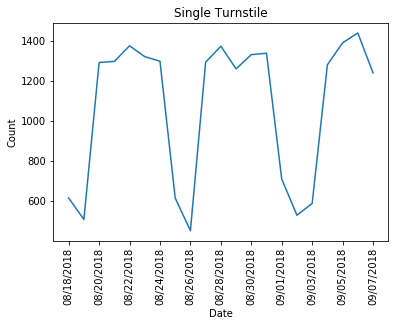

In [8]:
# Plot entries for one turnstile as a function of time #
# Note, additional filtering would be required if the .csv turnstile data files
# were not contiguous in time!
device = ['A002', 'R051', '02-00-00']
df_device = df_daily[(df_daily['C/A']==device[0])
                     & (df_daily['UNIT'] == device[1])
                     & (df_daily['SCP'] == device[2])]

xx = df_device.DATE
yy = df_device.ENTRY_DIFF

plt.plot(xx, yy);
plt.xticks(range(0, len(xx), 2),df_device.DATE[::2], rotation=90);
plt.xlabel('Date'); plt.ylabel('Count'); plt.title('Single Turnstile');

## Challenge 5

In [9]:
# Now sum across SCP devices within a station-control area-unit group #
df_daily_unit = df.groupby(['C/A','UNIT','DATE'])['ENTRY_DIFF'].sum().reset_index()
                # note: this could also be done with df_daily.groupby()
print(df_daily_unit)

         C/A  UNIT        DATE  ENTRY_DIFF
0       A002  R051  08/18/2018      7819.0
1       A002  R051  08/19/2018      6263.0
2       A002  R051  08/20/2018     11757.0
3       A002  R051  08/21/2018     12459.0
4       A002  R051  08/22/2018     12734.0
5       A002  R051  08/23/2018     12670.0
6       A002  R051  08/24/2018     12132.0
7       A002  R051  08/25/2018      7244.0
8       A002  R051  08/26/2018      5573.0
9       A002  R051  08/27/2018     11891.0
10      A002  R051  08/28/2018     12191.0
11      A002  R051  08/29/2018     12388.0
12      A002  R051  08/30/2018     12437.0
13      A002  R051  08/31/2018     11823.0
14      A002  R051  09/01/2018      7619.0
15      A002  R051  09/02/2018      6061.0
16      A002  R051  09/03/2018      5898.0
17      A002  R051  09/04/2018     11799.0
18      A002  R051  09/05/2018     12801.0
19      A002  R051  09/06/2018     13076.0
20      A002  R051  09/07/2018     11298.0
21      A006  R079  08/18/2018      5720.0
22      A00

## Challenge 6

In [10]:
# Now sum across the groups within a station #
df_daily_station = df.groupby(['STATION','DATE'])['ENTRY_DIFF'].sum().reset_index()

print(df_daily_station)

        STATION        DATE  ENTRY_DIFF
0          1 AV  08/18/2018     12719.0
1          1 AV  08/19/2018     10274.0
2          1 AV  08/20/2018     17181.0
3          1 AV  08/21/2018     18318.0
4          1 AV  08/22/2018     18776.0
5          1 AV  08/23/2018     18905.0
6          1 AV  08/24/2018     19781.0
7          1 AV  08/25/2018     14533.0
8          1 AV  08/26/2018     12019.0
9          1 AV  08/27/2018     17354.0
10         1 AV  08/28/2018     17946.0
11         1 AV  08/29/2018     18479.0
12         1 AV  08/30/2018     18438.0
13         1 AV  08/31/2018     18878.0
14         1 AV  09/01/2018     14045.0
15         1 AV  09/02/2018     11843.0
16         1 AV  09/03/2018     10059.0
17         1 AV  09/04/2018     17936.0
18         1 AV  09/05/2018     21049.0
19         1 AV  09/06/2018     21510.0
20         1 AV  09/07/2018     18647.0
21       103 ST  08/18/2018     17262.0
22       103 ST  08/19/2018     14011.0
23       103 ST  08/20/2018     27697.0


## Challenge 7

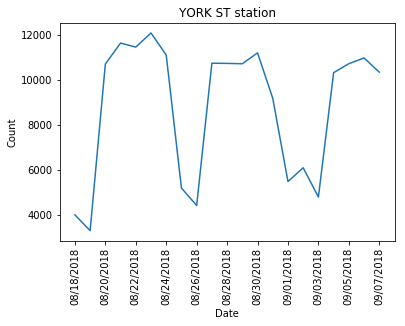

In [11]:
# Plot entries for one station as a function of time #
station = 'YORK ST'
df_station = df_daily_station[df_daily_station['STATION']==station]

xx = df_station.DATE
yy = df_station.ENTRY_DIFF

plt.plot(xx, yy);
plt.xticks(range(0, len(xx), 2),df_device.DATE[::2], rotation=90);
plt.xlabel('Date'); plt.ylabel('Count'); plt.title(f'{station} station');

## Challenge 8  -  stuck plotting by-week counts contained in arrays

In [12]:
# Add a column for day of week to the single-station dataframe #
temp = pd.to_datetime(df_station['DATE'],
                            format="%m/%d/%Y").dt.dayofweek   # Monday = 0, etc

df_station['DAY'] = list(temp)

/Users/neuromac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [53]:
# Accrue daily counts for multiple weeks for the chosen station #
nn, mm = list(df_station['ENTRY_DIFF']), list(df_station['DAY'])

xx = np.arange(0,7); xx = np.reshape(xx,[1,7])
yy0 = xx * np.nan    # create a single-week empty array
yy = yy0.copy()

_row = 0             # fill in array to store by-week ridership data
for i in range(0,len(nn)):  # note: partial weeks are retained
    yy[_row,mm[i]] = nn[i]
    if mm[i]==6:
        yy = np.append(yy,yy0,axis=0)
        _row += 1    # add on extra weeks as data is encountered

print(xx)            # the arrays look just like intended! this allows partial weeks
print(yy)

[[0 1 2 3 4 5 6]]
[[   nan    nan    nan    nan    nan  3992.  3290.]
 [10705. 11637. 11457. 12085. 11104.  5186.  4410.]
 [10742. 10732. 10717. 11200.  9180.  5476.  6089.]
 [ 4786. 10320. 10720. 10973. 10342.    nan    nan]]


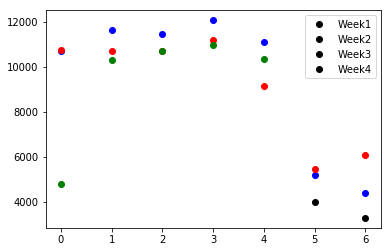

In [79]:
# Try to plot the daily counts across each week - unfortunately lines won't render #
COLOR_ORDER = ['k','b','r','g']
for i in range(0,len(yy)):
    plt.plot(xx,yy[i,:].reshape([1,7]),'o',color=COLOR_ORDER[i]);  # markers show up fine, however
plt.show;
plt.legend(['Week1','Week2','Week3','Week4'],loc=0);

## Challenge 9

In [43]:
# Sum across all dates to get the final station ranking #
df_total_station = df.groupby(['STATION'])['ENTRY_DIFF'].sum().reset_index()
df_total_station.sort_values('ENTRY_DIFF',ascending=False,inplace=True)

df_total_station.head()   # it looks like Pen Station at 34th St has the highest traffic

,STATION,ENTRY_DIFF
59,34 ST-PENN STA,2734989.0
229,GRD CNTRL-42 ST,2351853.0
57,34 ST-HERALD SQ,1867932.0
14,14 ST-UNION SQ,1753930.0
348,TIMES SQ-42 ST,1748572.0


## Challenge 10

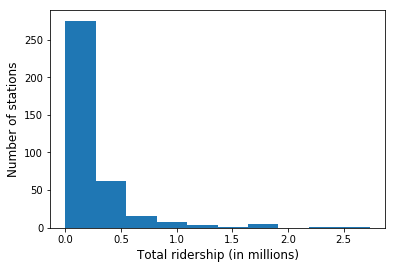

In [44]:
# Plot the ranked ridership data as a histogram #
plt.hist(df_total_station['ENTRY_DIFF']/1e6);
plt.xlabel('Total ridership (in millions)',fontsize=12);
plt.ylabel('Number of stations',fontsize=12);